# Novel variation

The analysis aimed to determine the number of potentially novel genetic variants within the selected genes of interest. Variants were classified as potentially novel if they did not have a [NCBI dbSNP rsID](https://customercare.23andme.com/hc/en-us/articles/212196908-What-Are-RS-Numbers-Rsid-#:~:text=The%20rsID%20number%20is%20a,convention%20used%20for%20most%20SNPs).

To achieve this, the following steps were performed:

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data underwent processing and preparation for analysis, following the steps outlined in the `Notebooks\Data_preparation\2-IH_allele_counts.ipynb` Jupyter notebook. The resulting prepared data includes variant rsIDs (if available), variant positional information, variant allele counts, variant allele frequencies, and the gene in which the variant was detected. This prepared data is stored in the `Data\Processed\IH_allele_counts.csv` file.
3. Data Filtering: Data on African American and African Caribbean subpopulations was removed to ensure that the variant data was representative of Recent African population groups only. Variant data from the `Data\Processed\IH_allele_counts.csv` file was filtered to include only information on the variant position, variant alleles, variant rsID (if available), and the associated gene.
4. Variant Classification: The number of variants with and without an rsID identifier were grouped and counted for each gene of interest. Variants lacking a dbsnp rsID identifier were classified as potentially novel.
5. Data Visualisation: The count of potentially novel variants without an rsID and non-novel variants with an rsID were visualised for each gene using a stacked barplot.

## Imports

Notebook setup

In [13]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions


Import variant data

In [14]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

ih_allele_counts.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE
0,chr13:110148882C-CT,110148882,C,CT,COL4A1,African Caribbean,0,228,110148882_CT_C,228,228,0.0,ACB,INDEL
1,chr13:110148882C-CT,110148882,C,CT,COL4A1,HGDP Yoruba,0,42,110148882_CT_C,42,42,0.0,WA,INDEL
2,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mandenka,0,46,110148882_CT_C,46,46,0.0,WA,INDEL
3,chr13:110148882C-CT,110148882,C,CT,COL4A1,Esan,0,296,110148882_CT_C,296,296,0.0,WA,INDEL
4,chr13:110148882C-CT,110148882,C,CT,COL4A1,Bantu Kenya,0,24,110148882_CT_C,24,24,0.0,EA,INDEL


## Data Filtering

Remove data for African American and African Caribbean subpopulations to ensure that the variant data was representative of Recent African population groups only. 

In [15]:
ih_allele_counts_recent_afr = ih_allele_counts[
        (ih_allele_counts.REG == "Recent African") & ~(ih_allele_counts.IH_ALT_CTS == 0)
    ]

ih_allele_counts_recent_afr.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE
29,rs552586867,110148891,C,G,COL4A1,NaN,2,1608,110148891_G_C,1608,1606,0.005714,Recent African,SNP
33,rs59409892,110148917,C,G,COL4A1,NaN,152,1608,110148917_G_C,1608,1456,1.106859,Recent African,SNP
203,rs546124548,110149176,T,A,COL4A1,NaN,1,1608,110149176_A_T,1608,1607,0.003378,Recent African,SNP
351,rs139916479,110149349,G,A,COL4A1,NaN,7,1608,110149349_A_G,1608,1601,0.081208,Recent African,SNP
387,rs552877576,110149494,C,T,COL4A1,NaN,2,1608,110149494_T_C,1608,1606,0.005682,Recent African,SNP


 Filter variant data to include only information on the variant position, variant alleles, variant rsID (if available), and the associated gene.

In [16]:
ih_allele_counts_recent_afr = ih_allele_counts_recent_afr.copy()[["VAR_NAME", "REF", "ALT", "POS", "GENE"]]

ih_allele_counts_recent_afr.head(5)

,VAR_NAME,REF,ALT,POS,GENE
29,rs552586867,C,G,110148891,COL4A1
33,rs59409892,C,G,110148917,COL4A1
203,rs546124548,T,A,110149176,COL4A1
351,rs139916479,G,A,110149349,COL4A1
387,rs552877576,C,T,110149494,COL4A1


## Variant classification

Group and count the number of variants with and without an rsID identifier for each gene of interest. Classify variants lacking a dbsnp rsID identifier as potentially novel. 

In [17]:
# Filter for variants without rsIDs

potential_novel_variants = ih_allele_counts_recent_afr[
    ~(ih_allele_counts.VAR_NAME.str.contains("rs"))
]

# Count the number of variants without rsIDs for each gene

potential_novel_variants_grouped = (
    functions.group_and_count(potential_novel_variants, ["GENE"])
    .reset_index()[["GENE", "VAR_NAME"]]
    .rename(columns={"VAR_NAME": "Potential novel"})
)

potential_novel_variants_grouped.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_19272\1442301943.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  potential_novel_variants = ih_allele_counts_recent_afr[


,GENE,Potential novel
0,AGT,264
1,AP4B1,29
2,CARD8,705
3,CAT,168
4,COL4A1,1160


In [18]:
# Count the total number of variants for each gene

recent_african_gene_count_grouped = (
    functions.group_and_count(ih_allele_counts_recent_afr, ["GENE"])
    .reset_index()[["GENE", "VAR_NAME"]]
    .rename(columns={"VAR_NAME": "TOTAL"})
)

recent_african_gene_count_grouped.head(5)

,GENE,TOTAL
0,AGT,1271
1,AP4B1,153
2,CARD8,2110
3,CAT,616
4,COL4A1,4060


In [19]:
# Combine the total variant and potentially novel variant count dataframes

total_and_novel_count = recent_african_gene_count_grouped.merge(potential_novel_variants_grouped, on=["GENE"]).set_index("GENE")

total_and_novel_count.head(5)

,TOTAL,Potential novel
GENE,,
AGT,1271,264
AP4B1,153,29
CARD8,2110,705
CAT,616,168
COL4A1,4060,1160


In [21]:
# Calculate number of non-novel variants with rsIDs

total_and_novel_count["Non-novel"] = total_and_novel_count.TOTAL - total_and_novel_count["Potential novel"]
total_and_novel_count.head(5)

,TOTAL,Potential novel,Non-novel
GENE,,,
AGT,1271,264,1007
AP4B1,153,29,124
CARD8,2110,705,1405
CAT,616,168,448
COL4A1,4060,1160,2900


Save gene counts

In [22]:
total_and_novel_count.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "Gene_variant_counts.csv",
    )
)

## Data visualisation

Set plot parameters

In [23]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a stacked bar plot of the potentially novel and non-novel variant counts per gene

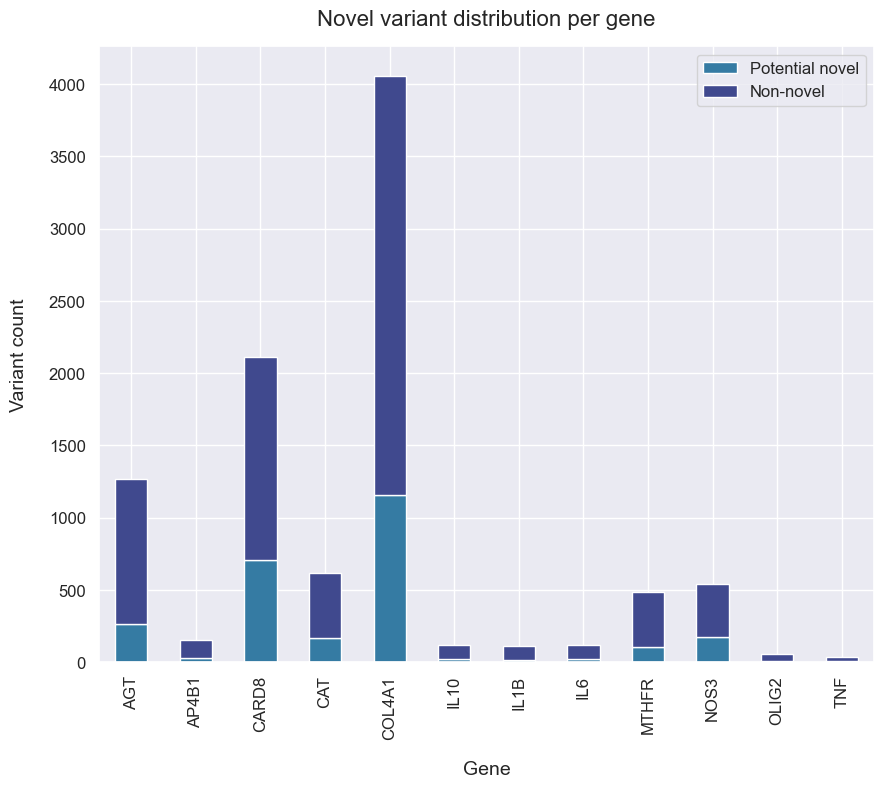

In [27]:
variant_barplot = functions.create_plot(
    plot_type="stacked_barplot",
    x="GENE",
    palette=["#357BA3", "#40498E"],
    data=total_and_novel_count[["Potential novel", "Non-novel"]],
)

plt.xlabel(xlabel="Gene", labelpad=15)
plt.ylabel(ylabel="Variant count", labelpad=15)

plt.legend(
    loc="upper right",
    frameon=True
)

plt.title(
    "Novel variant distribution per gene", size=constants.LARGEST_FONT, pad=15
)

plt.savefig("..\Results\Figures\Gene_novel_variant_count.png", dpi=1200)
plt.show()